In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df_main = pd.read_csv("credit_card_transactions-ibm_v2.csv")
df_users = pd.read_csv("sd254_users.csv")
df_cards = pd.read_csv("sd254_cards.csv")

### Steps in Implementing Credit Card Fraud Detection
1. Reading, understanding and visualizing data - Exploratory Data Analysis
3. Preparing the data for modelling
4. Building the model
5. Evaluate the model


## 1. Reading, understanding, and visualizing data - EDA
Cleaning up Dataset - used for creating a smaller, representative dataset for analysis or testing, or for sampling users for further processing.

In [3]:
users = df_main['User'].unique()  # Extracts all unique users from df_main
selected_trans = pd.Series(users).sample(frac=0.4, replace=False, random_state=42) # Selecting a Random Sample of Users
filtered = df_main[df_main['User'].isin(selected_trans)] # Filtering Transactions Based on Selected Users

In [4]:
df=filtered.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 1.2+ GB


In [6]:
df.head() # this is the sample of the large dataset with randomly selected users

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
28882,2,0,2009,9,26,01:56,$948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,No
28883,2,0,2009,10,1,04:13,$42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28884,2,0,2009,10,1,10:49,$9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,No
28885,2,0,2009,10,1,14:30,$36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28886,2,0,2009,10,2,04:25,$56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No


In [7]:
df['Is Fraud?'].value_counts() # checking the number of fraudulent transactions

Is Fraud?
No     9676336
Yes      11729
Name: count, dtype: int64

In [8]:
df.isnull().sum() # checking for missing values in the columns

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    1132934
Zip               1197293
MCC                     0
Errors?           9532311
Is Fraud?               0
dtype: int64

In [9]:
df['Merchant City'].value_counts()

Merchant City
ONLINE             1132934
Houston             161111
Chicago              83921
Dallas               66550
Miami                60492
                    ...   
Craigsville              1
Bosque                   1
Veyo                     1
Pleasant Unity           1
Laurel Bloomery          1
Name: count, Length: 11640, dtype: int64

In [10]:
df['MCC'].value_counts()

MCC
5411    1118044
5499    1090292
5541    1054070
5812     702784
5912     536227
         ...   
3007        275
4411        258
5722        246
3144        243
5733        180
Name: count, Length: 109, dtype: int64

## 2. Preparing the data for modelling

In [11]:
# We need to remove the '$' to change the attribute as float - to ease the data processing
df['Amount'] = df['Amount'].str.replace('$', '').astype(float)

In [12]:
# Need to separate hour and minute to perform a better time series analysis
df['Hour'] = df['Time'].str[0:2]
df['Minute'] = df['Time'].str[3:5]
df = df.drop(['Time'], axis=1)

In [13]:
# We also need the change the Fraud column from string to boolean values, where 1 = 'Yes', 0 = 'No'
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x:1 if x == 'Yes' else 0)

In [14]:
df['Errors?'].fillna('Unknown', inplace=True)
# for the missing values in the column 'Errors?', I filled it in with 'Unknown'

/var/folders/0m/d4xwfvr11f9g7yflwxh0w_c40000gn/T/ipykernel_64603/218366416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Errors?'].fillna('Unknown', inplace=True)


In [15]:
df['Errors?'].head()

28882    Unknown
28883    Unknown
28884    Unknown
28885    Unknown
28886    Unknown
Name: Errors?, dtype: object

In [16]:
# The number of missing values in Merchant State is the same as the number of Online transactions in Merchant City
# So I will be filling in the missing values of Merchant State as 'ONLINE'
df.loc[(df['Merchant City'] == 'ONLINE') & (df['Merchant State'].isnull()), 'Merchant State'] = 'ONLINE'

In [17]:
df['Merchant City'].value_counts()

Merchant City
ONLINE             1132934
Houston             161111
Chicago              83921
Dallas               66550
Miami                60492
                    ...   
Craigsville              1
Bosque                   1
Veyo                     1
Pleasant Unity           1
Laurel Bloomery          1
Name: count, Length: 11640, dtype: int64

In [18]:
df['Zip'].astype(str)

28882           nan
28883           nan
28884       91792.0
28885           nan
28886           nan
             ...   
24382134    17011.0
24382135    17042.0
24382136    17011.0
24382137    17011.0
24382138    17011.0
Name: Zip, Length: 9688065, dtype: object

In [19]:
# Filling missing Zip values with 'ONLINE' if Merchant City and Merchant State are both 'ONLINE'
df.loc[(df['Merchant City'] == 'ONLINE') & (df['Merchant State'] == 'ONLINE') & (df['Zip'].isnull()), 'Zip'] = 'ONLINE'

/var/folders/0m/d4xwfvr11f9g7yflwxh0w_c40000gn/T/ipykernel_64603/1826326407.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ONLINE' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Merchant City'] == 'ONLINE') & (df['Merchant State'] == 'ONLINE') & (df['Zip'].isnull()), 'Zip'] = 'ONLINE'


In [20]:
df.isnull().sum()

User                  0
Card                  0
Year                  0
Month                 0
Day                   0
Amount                0
Use Chip              0
Merchant Name         0
Merchant City         0
Merchant State        0
Zip               64359
MCC                   0
Errors?               0
Is Fraud?             0
Hour                  0
Minute                0
dtype: int64

In [21]:
df['Zip'] = df['Zip'].fillna('Unknown')

In [22]:
df.isnull().sum()

User              0
Card              0
Year              0
Month             0
Day               0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Errors?           0
Is Fraud?         0
Hour              0
Minute            0
dtype: int64

In [23]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
28882,2,0,2009,9,26,948.44,Online Transaction,3694722044710185708,ONLINE,ONLINE,ONLINE,4722,Unknown,0,01,56
28883,2,0,2009,10,1,42.98,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,04,13
28884,2,0,2009,10,1,9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,Unknown,0,10,49
28885,2,0,2009,10,1,36.39,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,14,30
28886,2,0,2009,10,2,56.60,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,04,25


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Amount          float64
 6   Use Chip        object 
 7   Merchant Name   int64  
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             object 
 11  MCC             int64  
 12  Errors?         object 
 13  Is Fraud?       int64  
 14  Hour            object 
 15  Minute          object 
dtypes: float64(1), int64(8), object(7)
memory usage: 1.2+ GB


### 3. Exploratory Data Analysis

In [25]:
fraud_data = df[df['Is Fraud?'] == 1]

<function matplotlib.pyplot.show(close=None, block=None)>

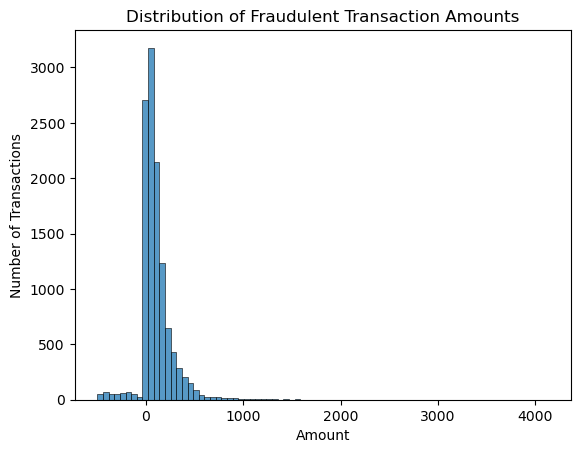

In [26]:
sb.histplot(fraud_data['Amount'].astype(float), kde = False, bins = 80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.show

From the figure above, we can infer that most of the 'fraud' amounts ranges from 0-250, meaning that fraudulent transaction is more likely to occur for small transactions.

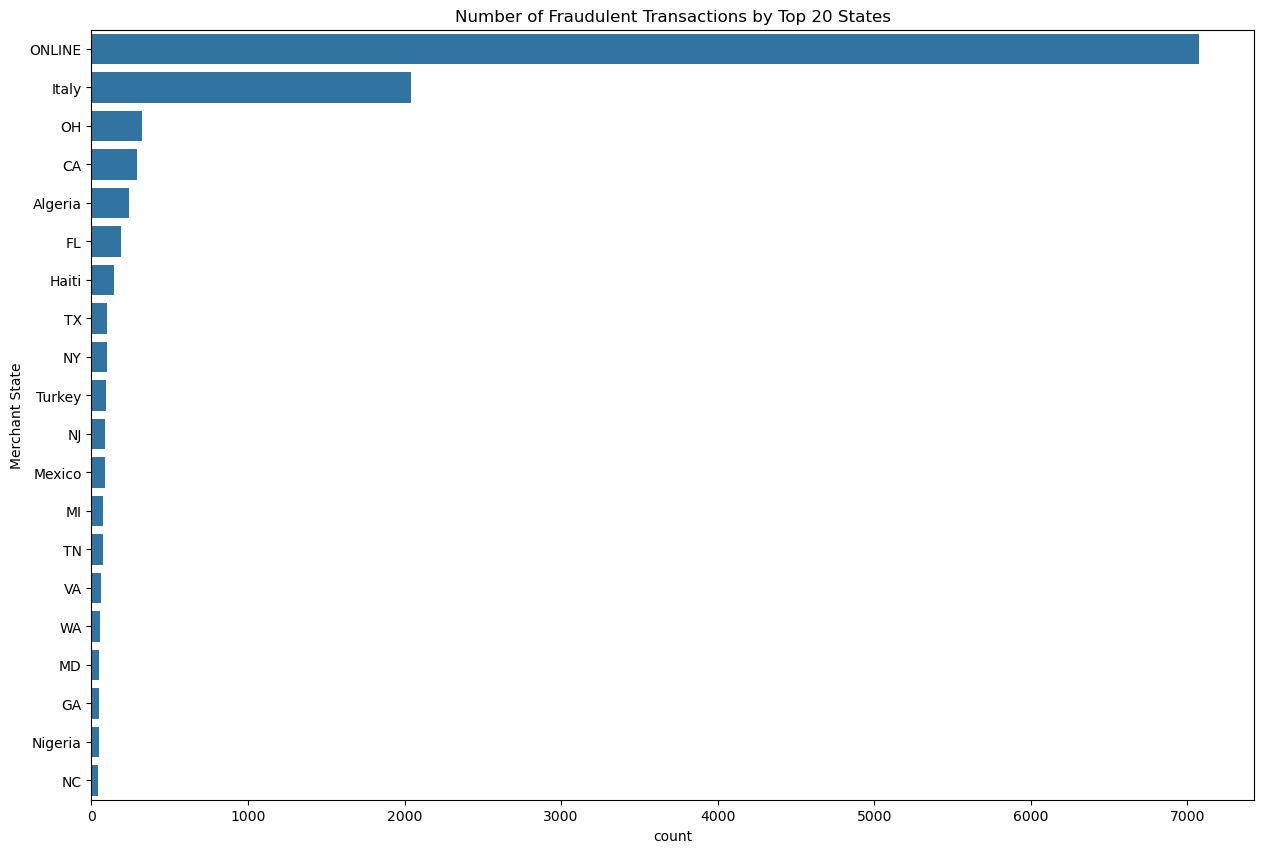

In [27]:
plt.figure(figsize=(15,10))
top_20_states = fraud_data['Merchant State'].value_counts().head(20).index.tolist()
sb.countplot(data=fraud_data, y= "Merchant State", order = top_20_states)
plt.title('Number of Fraudulent Transactions by Top 20 States')
plt.show()

'Merchant State' includes states in the US and other countries, and in terms of country, there is a large contribution of fraudulent actions in Italy, Algeria, Haiti and Turkey. In terms of the states in the US, high contributions in Ohio, California, and Florida. However, the most contribution of the fraudulent transaction is still 'ONLINE'

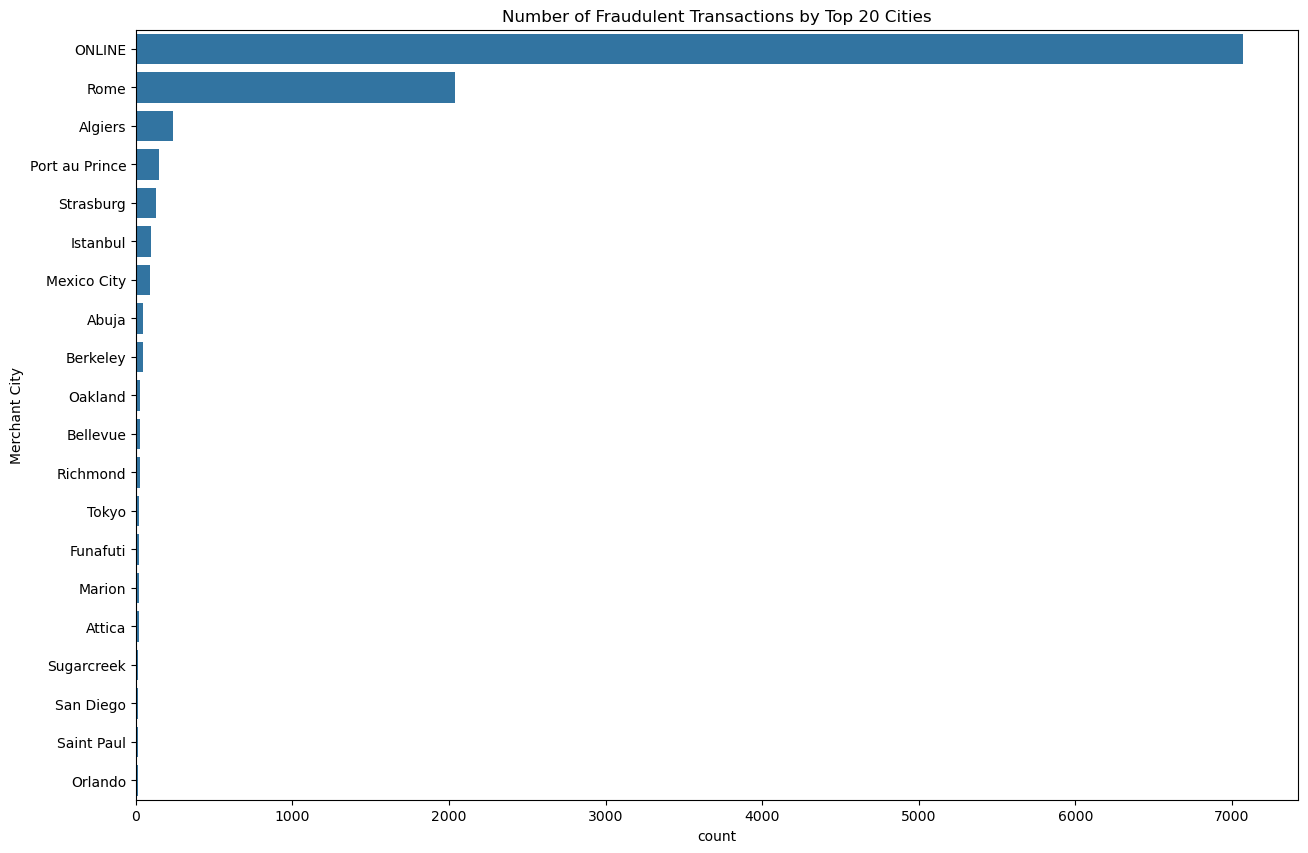

In [28]:
plt.figure(figsize=(15, 10))
top_20_cities = fraud_data['Merchant City'].value_counts().head(20).index
sb.countplot(data=fraud_data, y='Merchant City', order=top_20_cities)
plt.title('Number of Fraudulent Transactions by Top 20 Cities')
plt.show()

Fraud primarily takes place in online transactions. Furthermore, cities like Rome, Algiers, and Port-au-Prince are significant hotspots with high levels of fraudulent activity.

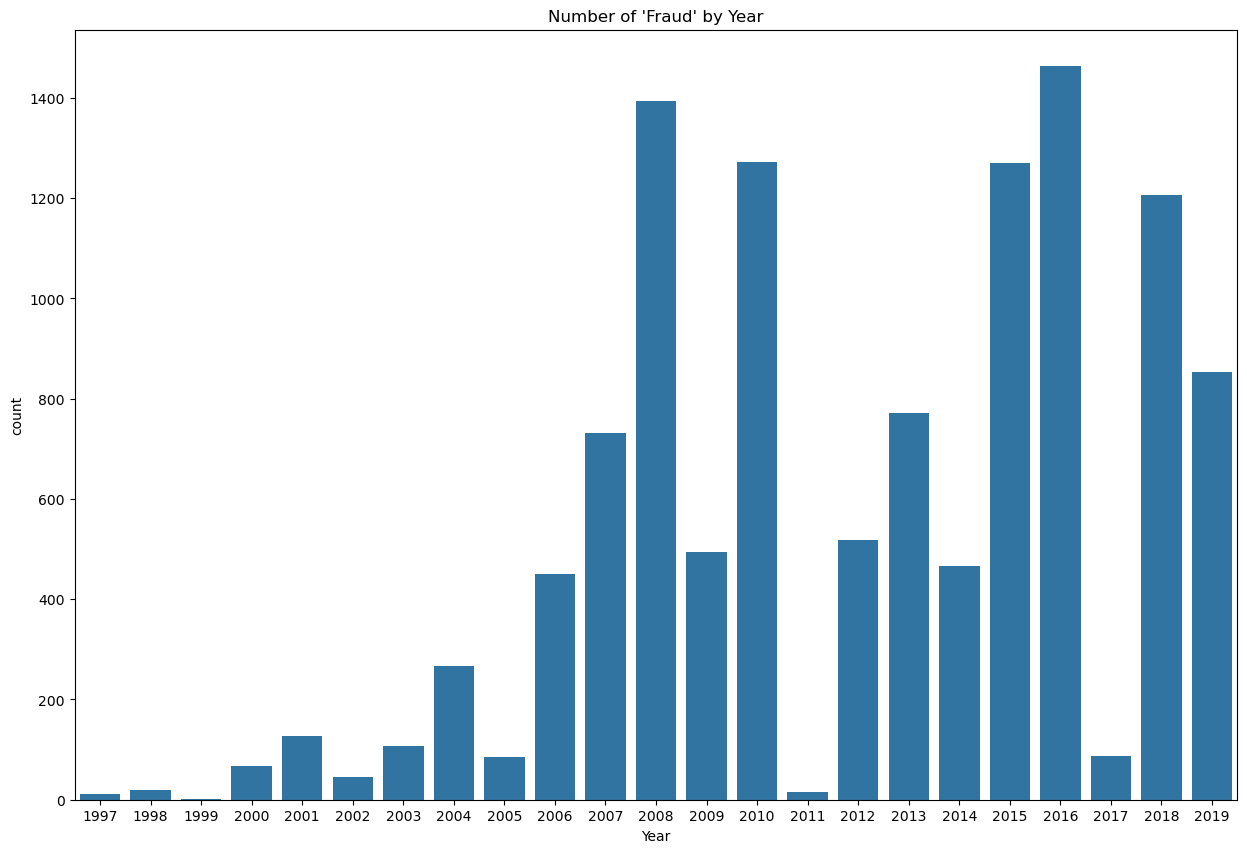

In [29]:
plt.figure(figsize=(15,10))
sb.countplot(data=fraud_data, x='Year')
plt.title("Number of 'Fraud' by Year")
plt.show()

During the 20th centuery, th number of fraudulent transaction was low, as the credit card system and internet was still not quite developed like today, entering the 21st century, the number of fraud has risen steadily then a huge drop in 2011 (likely due to the enhanced cybersecurity system). 

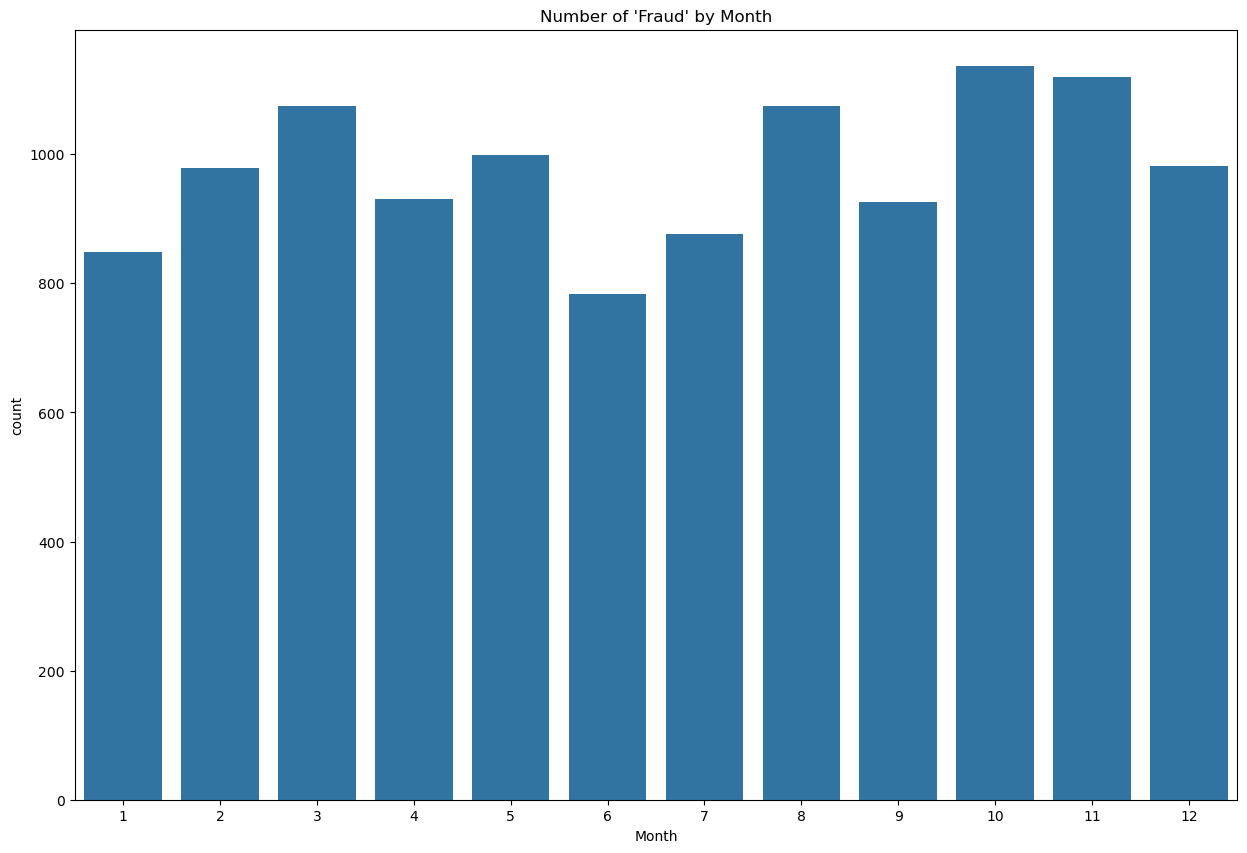

In [30]:
plt.figure(figsize=(15,10))
sb.countplot(data=fraud_data, x='Month')
plt.title("Number of 'Fraud' by Month")
plt.show()

just from the figure, we can't really say that which specific month has a drastic number of frauds, it is quite evenly distributed where the peak month at which there was the most fraudulent transaction is October.

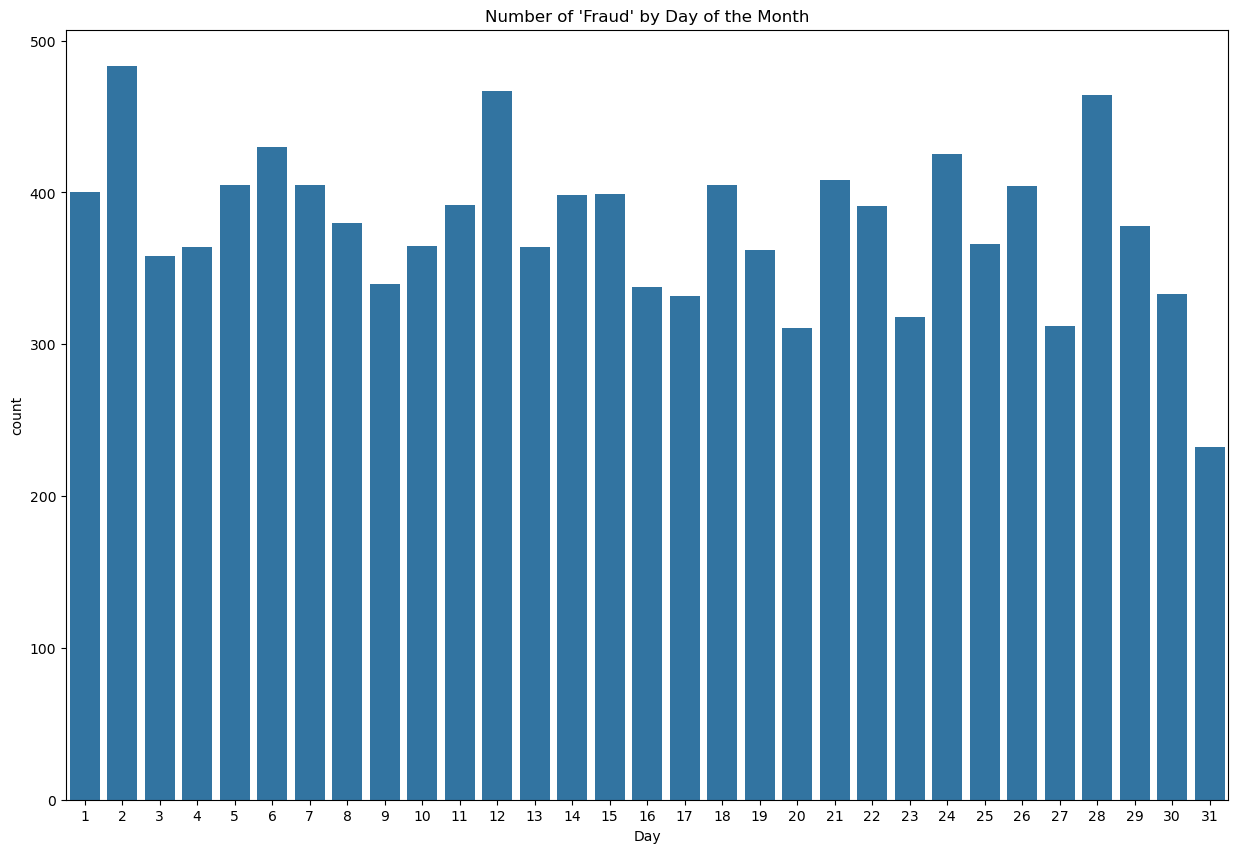

In [31]:
plt.figure(figsize=(15,10))
sb.countplot(data=fraud_data, x='Day')
plt.title("Number of 'Fraud' by Day of the Month")
plt.show()

Just like the distribution in month, there isn't really a huge variation between the days. 

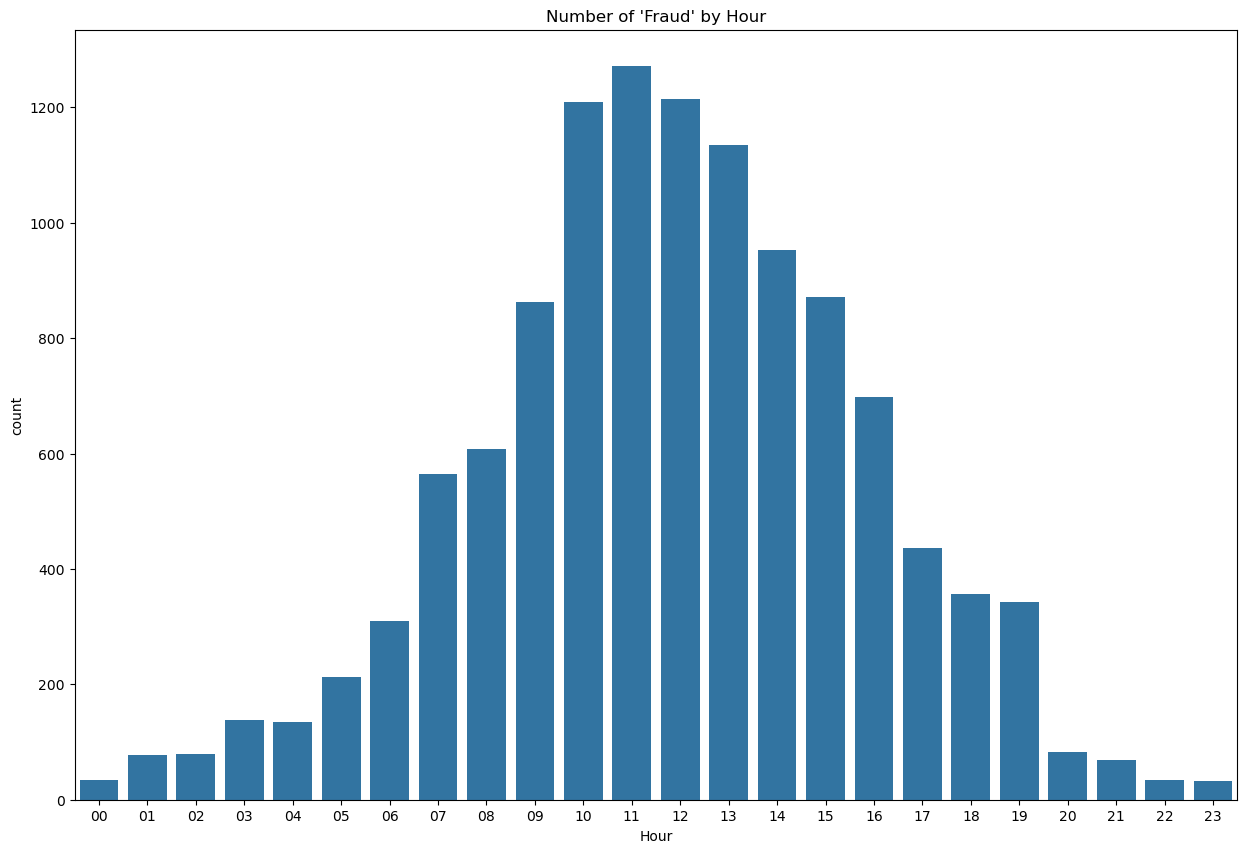

In [32]:
plt.figure(figsize=(15,10))
sb.countplot(data=fraud_data, x='Hour', order = sorted(fraud_data['Hour'].unique()))
plt.title("Number of 'Fraud' by Hour")
plt.show()

The peak hours in which most fraudulent activities occur us around noon, more specifically, around 11-12

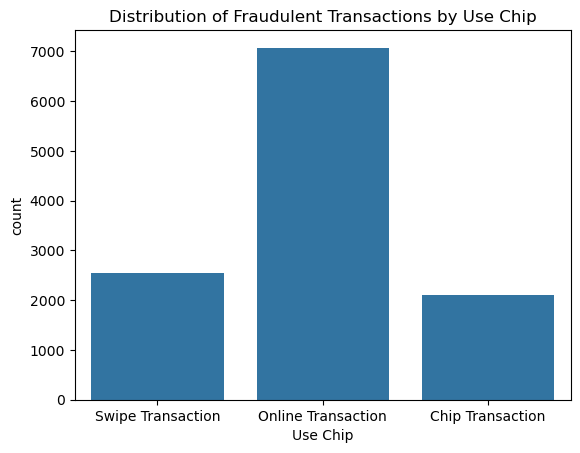

In [33]:
sb.countplot(data=fraud_data, x = 'Use Chip')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

Online Transaction showcases the highest likelihood to fraud.

## Building the Model

### Binary encoding - to encode categorical variable into numeric variable as KNN requires all input features to be numerical.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Amount          float64
 6   Use Chip        object 
 7   Merchant Name   int64  
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             object 
 11  MCC             int64  
 12  Errors?         object 
 13  Is Fraud?       int64  
 14  Hour            object 
 15  Minute          object 
dtypes: float64(1), int64(8), object(7)
memory usage: 1.2+ GB


In [35]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
28882,2,0,2009,9,26,948.44,Online Transaction,3694722044710185708,ONLINE,ONLINE,ONLINE,4722,Unknown,0,01,56
28883,2,0,2009,10,1,42.98,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,04,13
28884,2,0,2009,10,1,9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,Unknown,0,10,49
28885,2,0,2009,10,1,36.39,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,14,30
28886,2,0,2009,10,2,56.60,Online Transaction,-6458444334611773637,ONLINE,ONLINE,ONLINE,4784,Unknown,0,04,25


In [36]:
import category_encoders as ce

df['Hour'] = df['Hour'].astype('float')
df['Minute'] = df['Minute'].astype('float')

cols_to_encode = ['Use Chip', 'Merchant City', 'Merchant State', 'Zip', 'Errors?']

for col in cols_to_encode:
    if col in df.columns:
        be = ce.BinaryEncoder(drop_invariant=False)
        encoded_df = pd.DataFrame(be.fit_transform(df[col]), dtype = 'int8')
        df = pd.concat([df, encoded_df], axis = 1)
        df.drop([col], axis=1, inplace = True)

    #for col in df.columns:
        #df[col] = df[col].astype(float)



In [37]:
df.head()

,User,Card,Year,Month,Day,Amount,Merchant Name,MCC,Is Fraud?,Hour,...,Zip_10,Zip_11,Zip_12,Zip_13,Zip_14,Errors?_0,Errors?_1,Errors?_2,Errors?_3,Errors?_4
28882,2,0,2009,9,26,948.44,3694722044710185708,4722,0,1.0,...,0,0,0,0,1,0,0,0,0,1
28883,2,0,2009,10,1,42.98,-6458444334611773637,4784,0,4.0,...,0,0,0,0,1,0,0,0,0,1
28884,2,0,2009,10,1,9.85,-4891055843221560993,5411,0,10.0,...,0,0,0,1,0,0,0,0,0,1
28885,2,0,2009,10,1,36.39,-6458444334611773637,4784,0,14.0,...,0,0,0,0,1,0,0,0,0,1
28886,2,0,2009,10,2,56.60,-6458444334611773637,4784,0,4.0,...,0,0,0,0,1,0,0,0,0,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 55 columns):
 #   Column            Dtype  
---  ------            -----  
 0   User              int64  
 1   Card              int64  
 2   Year              int64  
 3   Month             int64  
 4   Day               int64  
 5   Amount            float64
 6   Merchant Name     int64  
 7   MCC               int64  
 8   Is Fraud?         int64  
 9   Hour              float64
 10  Minute            float64
 11  Use Chip_0        int8   
 12  Use Chip_1        int8   
 13  Merchant City_0   int8   
 14  Merchant City_1   int8   
 15  Merchant City_2   int8   
 16  Merchant City_3   int8   
 17  Merchant City_4   int8   
 18  Merchant City_5   int8   
 19  Merchant City_6   int8   
 20  Merchant City_7   int8   
 21  Merchant City_8   int8   
 22  Merchant City_9   int8   
 23  Merchant City_10  int8   
 24  Merchant City_11  int8   
 25  Merchant City_12  int8   
 26  Merchant City_

### Data Preprocessing

In [39]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [40]:
# Define features (X) and target (y)
X = df.drop('Is Fraud?', axis=1)
y = df['Is Fraud?']


### Under sampling
Due to the limitation of computational capacity, I subset 50,000 data with 20% of them being fraud cases in order to balance the proportion and ensure model performance. 

In [41]:
proportion = 0.2
total_samples = 50000
fraud_samples = int(total_samples * proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0:total_samples - fraud_samples, 1:fraud_samples}, random_state = 42)

# apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)



In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state = 42)

### Data Scaling

In [45]:
from sklearn.preprocessing import StandardScaler # used for standardizing features (scaling them to have zero mean and unit variance)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training and Evaluation

In [46]:
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # make predictions

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# print accuracy score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10010
           1       0.84      0.79      0.82      2490

    accuracy                           0.93     12500
   macro avg       0.90      0.88      0.89     12500
weighted avg       0.93      0.93      0.93     12500

Accuracy Score:  0.92896


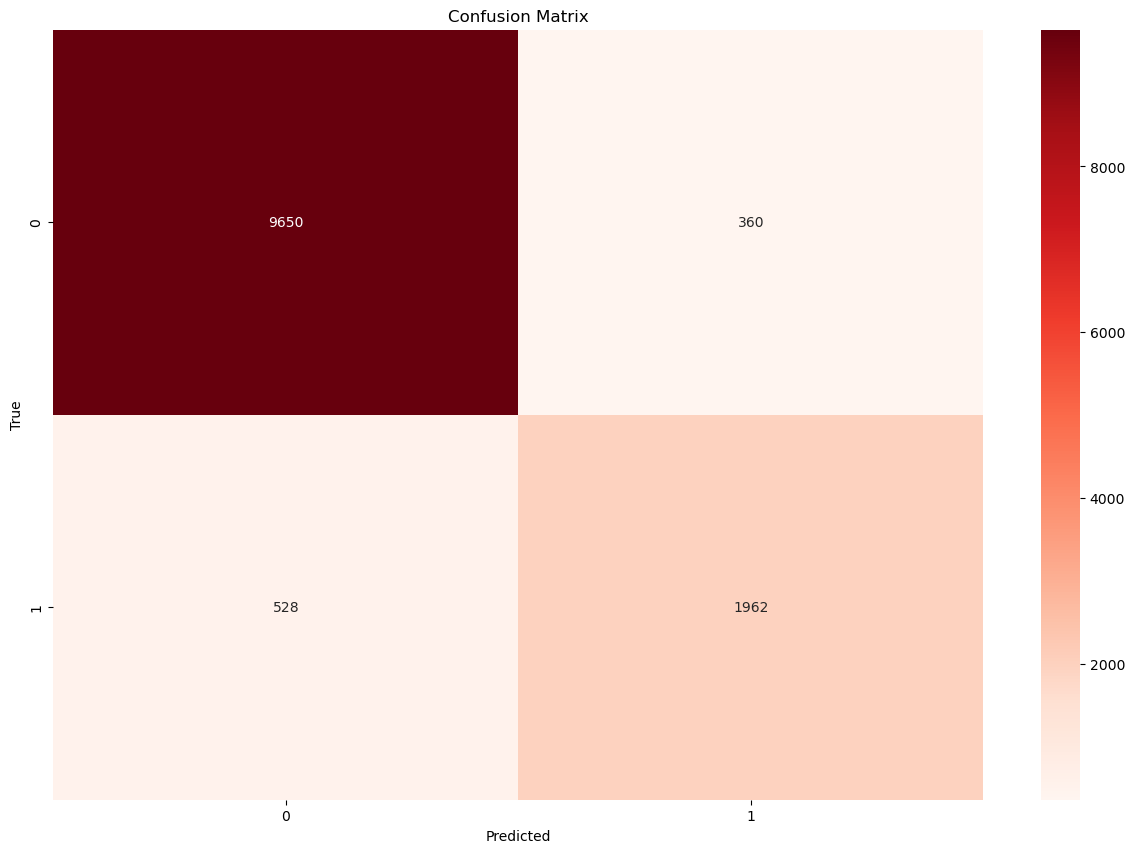

In [49]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,10))
sb.heatmap(cm, annot = True, fmt = 'd', cmap = 'Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

TN = 9650 -> 9650 transaction were correctly identified as non-fradulent by the model, 
TP = 1962 -> 1962 transaction were correctly identified as fradulent by the model, 
FN = 528 -> 528 transaction were wrongly identified as non-fradulent by the model, 
FP = 360 -> 360 transaction were wrongly identified as fradulent by the model

## Conclusion

The K-Nearest Neighbors (KNN) algorithm, despite its simplicity, has proven to be a formidable method for classification tasks, including those that are intricate and critical, such as fraud detection in credit card transactions.